In [1]:
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, Dropout
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import f1_score
from keras.regularizers import l2
np.random.seed(7)

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
MAX_SEQUENCE_LENGTH = 15
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300

In [161]:
data = pd.read_csv("bitcoin_data.csv")
test_data = pd.read_csv("data.csv", low_memory=False)

In [162]:
data.head()

,Timestamp,Username,Label,Tweet,URL
0,"March 14, 2018 at 09:47PM",@RizkyF_404,spam,RT @kickcity_io: Token Kart added KickCity to ...,http://twitter.com/RizkyF_404/status/973903509...
1,"March 14, 2018 at 09:47PM",@exchangebutler,spam,RT @Denaro_io: Our support team is here to hel...,http://twitter.com/exchangebutler/status/97390...
2,"March 14, 2018 at 09:47PM",@Bilalbinsaqib,pos,$eth trendline broke\nnext support @600 and th...,http://twitter.com/Bilalbinsaqib/status/973903...
3,"March 14, 2018 at 09:47PM",@ahsen_soydan,spam,RT @ahsen_soydanvip: 💎 High Quality Partner ✔️...,http://twitter.com/ahsen_soydan/status/9739035...
4,"March 14, 2018 at 09:47PM",@mourneopened,hype,RT @izx_io: IZETEX is on the Battle of the Cry...,http://twitter.com/mourneopened/status/9739035...


In [163]:
test_data.head()

,Unnamed: 0,Link,TImestamp,Timestamp,Tweet,User
0,0,http://twitter.com/pehlivanhakki/status/903407...,"September 01, 2017 at 12:00AM",NaN,RT @maxkeiser: Just $200 away from $5k. #Bitco...,@pehlivanhakki
1,1,http://twitter.com/torisamadotcom/status/90340...,"September 01, 2017 at 12:00AM",NaN,RT @missbitcoin_mai: 昨日はドイツのメディア🇩🇪日本のメディア🇯🇵最後は...,@torisamadotcom
2,2,http://twitter.com/dignetdesigns/status/903407...,"September 01, 2017 at 12:00AM",NaN,RT @AAlNaggar: What is a #Bitcoin and how does...,@dignetdesigns
3,3,http://twitter.com/coins24by7/status/903407191...,"September 01, 2017 at 12:00AM",NaN,"#bitcoin Price: $4,735.04 Chg: 3.08% Vol: $333...",@coins24by7
4,4,http://twitter.com/aguptaindia/status/90340719...,"September 01, 2017 at 12:00AM",NaN,RT @CryptoNewswire: Top 6 BTC/USD Exchange Ord...,@aguptaindia


In [164]:
data = pd.DataFrame.dropna(data)
data = pd.DataFrame.drop_duplicates(data)

In [165]:
data = data[data.Label != 'neutral']

In [166]:
# Match test data to training data
test_data['URL'] = test_data['Link']
test_data['Username'] = test_data['User']
test_data['Timestamp'] = test_data['Timestamp'].fillna('')
test_data['TImestamp'] = test_data['TImestamp'].fillna('')
test_data['Timestamp'] = test_data['TImestamp'].map(str) + test_data['Timestamp']
test_data = test_data.drop(columns=['TImestamp', 'Link', 'User'])

In [167]:
test_data

,Unnamed: 0,Timestamp,Tweet,URL,Username
0,0,"September 01, 2017 at 12:00AM",RT @maxkeiser: Just $200 away from $5k. #Bitco...,http://twitter.com/pehlivanhakki/status/903407...,@pehlivanhakki
1,1,"September 01, 2017 at 12:00AM",RT @missbitcoin_mai: 昨日はドイツのメディア🇩🇪日本のメディア🇯🇵最後は...,http://twitter.com/torisamadotcom/status/90340...,@torisamadotcom
2,2,"September 01, 2017 at 12:00AM",RT @AAlNaggar: What is a #Bitcoin and how does...,http://twitter.com/dignetdesigns/status/903407...,@dignetdesigns
3,3,"September 01, 2017 at 12:00AM","#bitcoin Price: $4,735.04 Chg: 3.08% Vol: $333...",http://twitter.com/coins24by7/status/903407191...,@coins24by7
4,4,"September 01, 2017 at 12:00AM",RT @CryptoNewswire: Top 6 BTC/USD Exchange Ord...,http://twitter.com/aguptaindia/status/90340719...,@aguptaindia
5,5,"September 01, 2017 at 12:00AM",Join the casino club at https://t.co/ZSV6pMtlX...,http://twitter.com/betbybitcoins/status/903407...,@betbybitcoins
6,6,"September 01, 2017 at 12:00AM",#Bitcoin $4704.98 (d.+3.08%) #BTC\n#Ethereum $...,http://twitter.com/BitcoinRater/status/9034072...,@BitcoinRater
7,7,"September 01, 2017 at 12:00AM",RT @golangnews: Building a blockchain in go #b...,http://twitter.com/cool_golang/status/90340722...,@cool_golang
8,8,"September 01, 2017 at 12:07AM",RT @HashRushGame: The last chance to participa...,http://twitter.com/EvgPerevozchiko/status/9034...,@EvgPerevozchiko
9,9,"September 01, 2017 at 12:07AM",RT @WhalePanda: I never had any #Bitcoin to be...,http://twitter.com/Mr_CryptoRobot/status/90340...,@Mr_CryptoRobot


## Multi-class classification system with 5 classes

In [168]:
print(len(data.Label.unique()))
print(len(data))

5
1338


Label
doom     62
hype    177
neg      91
pos     211
spam    797
dtype: int64


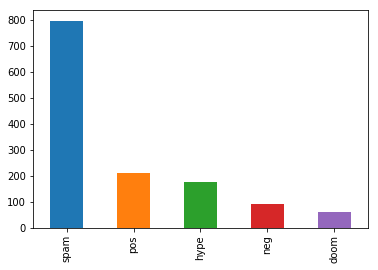

In [169]:
print(data.groupby('Label').size())
%matplotlib inline
import matplotlib as plt
data['Label'].value_counts().plot(kind="bar")

In [170]:
texts = data["Tweet"].values
test_texts = test_data["Tweet"].values
labels = data["Label"].values

## Cleaning tweets

In [171]:
# stemming + stopword_removal

import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

def stemming_stopword_removal(texts):
    text = []
    for i in range(0, len(texts)):
        tweet = re.sub('[^a-zA-Z\s+]','', texts[i])
        tweet = re.sub(r'http\S+', '', texts[i]).lower().split()
        tweet = [word for word in tweet if not word in set(stopwords.words('english'))]
        tweet = ' '.join(tweet)
        text.append(tweet)
    text = np.asarray(text)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/johnlau/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [172]:
text = stemming_stopword_removal(texts)
text.shape

(1338,)

In [173]:
test_text = stemming_stopword_removal(test_texts)
test_text.shape

(134239,)

In [174]:
combined_text = np.concatenate((text, test_text), axis=None)
combined_text.shape

(135577,)

In [175]:
# tokenizing and sequencing
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
# Combine training and test texts to ensure all tokens available to prevent prediction error
tokenizer.fit_on_texts(combined_text)
sequences = tokenizer.texts_to_sequences(text)
test_sequences = tokenizer.texts_to_sequences(test_text)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 71124 unique tokens.


In [176]:
df = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
test_df = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [177]:
print('Training data frame shape', df.shape)
print('Test data frame shape', test_df.shape)

Training data frame shape (1338, 15)
Test data frame shape (134239, 15)


In [178]:
target_names = data.Label.unique() # list of label ids
target_dict = {n:i for i, n in enumerate(target_names)} # list of label names
labels = data.Label.map(target_dict)
labels = to_categorical(np.asarray(labels))

In [179]:
target_dict

{'spam': 0, 'pos': 1, 'hype': 2, 'neg': 3, 'doom': 4}

In [180]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1338, 5)
Shape of label tensor: (1338, 5)


In [181]:
# Shuffle the training data frame
indices = np.arange(df.shape[0])
np.random.shuffle(indices)
data = df[indices]
labels = labels[indices]

In [182]:
X = data
y = labels

In [183]:
# split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)

## Pre-training on Glove embeddings

In [184]:
# embedding matrx
embeddings_index = {}
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# embedding matrix
count = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, index in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[index] = embedding_vector
    else:
        count += 1
print(count) 


# embedding layer
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) 

Found 400000 word vectors.
47764


In [185]:
# build model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(128, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(len(target_names), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['acc'])

In [186]:
model.fit(X_train, y_train,
          batch_size=32,
          epochs=4, validation_data=(X_test, y_test))

Train on 1070 samples, validate on 268 samples
Epoch 1/4
1070/1070 [==============================] - 14s 13ms/step - loss: 1.1356 - acc: 0.5710 - val_loss: 1.0799 - val_acc: 0.5896
Epoch 2/4
1070/1070 [==============================] - 12s 12ms/step - loss: 0.8108 - acc: 0.7056 - val_loss: 1.0854 - val_acc: 0.5858
Epoch 3/4
1070/1070 [==============================] - 12s 11ms/step - loss: 0.5524 - acc: 0.8093 - val_loss: 1.3031 - val_acc: 0.5858
Epoch 4/4
1070/1070 [==============================] - 12s 11ms/step - loss: 0.3467 - acc: 0.8888 - val_loss: 1.3659 - val_acc: 0.5821


In [187]:
y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_class, y_pred_class, digits=3))

             precision    recall  f1-score   support

          0      0.710     0.872     0.783       149
          1      0.250     0.140     0.179        43
          2      0.312     0.244     0.274        41
          3      0.294     0.294     0.294        17
          4      0.417     0.278     0.333        18

avg / total      0.530     0.582     0.547       268



In [188]:
target_dict

{'spam': 0, 'pos': 1, 'hype': 2, 'neg': 3, 'doom': 4}

In [189]:
test_prediction = model.predict(test_df)

In [190]:
test_prediction

array([[8.4184057e-01, 1.1127404e-01, 2.7888753e-02, 1.7866502e-02,
        1.1301355e-03],
       [5.1243418e-01, 3.0959821e-01, 9.8000348e-02, 6.6769049e-02,
        1.3198220e-02],
       [9.5601268e-02, 5.6074530e-02, 2.4632268e-02, 5.5127025e-01,
        2.7242166e-01],
       ...,
       [2.5324789e-01, 3.4108391e-01, 1.6322091e-01, 7.0757329e-02,
        1.7168996e-01],
       [9.5204204e-01, 1.8265758e-02, 2.3055837e-02, 2.8018721e-03,
        3.8344632e-03],
       [8.7308413e-01, 1.1709824e-01, 7.5051598e-03, 1.8830904e-03,
        4.2927719e-04]], dtype=float32)

In [234]:
# Get the index of the maximum value by each row
predicted_class = np.argmax(test_prediction, axis=1)
predicted_class.shape

(134239,)

In [257]:
import datetime

NUM_TO_PLOT = 50
predicted_datetime = []

# String to datetime object. Timezone follows the machine which in this case JST
for str_dt in test_data[:NUM_TO_PLOT]['Timestamp']:
    dt = datetime.datetime.strptime(str_dt, '%B %d, %Y at %I:%M%p')
    predicted_datetime.append(dt.timestamp())

min_predicted_datetime = min(predicted_datetime)
max_predicted_datetime = max(predicted_datetime)
print('Minimum timestamp', min_predicted_datetime)
print('Maximum timestamp', max_predicted_datetime)

Minimum timestamp 1504191600.0
Maximum timestamp 1504192620.0


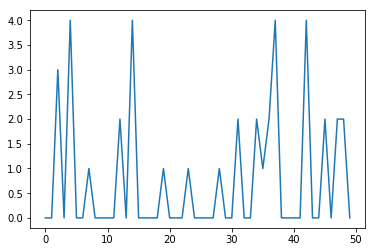

In [259]:
series = pd.Series(predicted_class[:50])
series.plot()

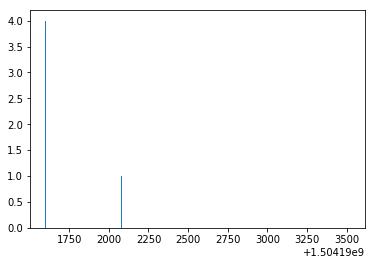

In [241]:
import matplotlib.pyplot as plt

plt.bar(predicted_datetime[:100], predicted_class[:100])

# get current axis
# ax = plt.gca()
# get current xtick labels
# xticks = ax.get_xticks()
# convert all xtick labels to selected format
# ax.set_xticklabels([pd.to_datetime(tm, unit='s', utc=True).strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks], rotation=50)

plt.show()

In [191]:
predicted_spam = test_prediction[:,0]
predicted_positive = test_prediction[:,1]
predicted_hype = test_prediction[:,2]
predicted_negative = test_prediction[:,3]
predicted_doom = test_prediction[:,4]

In [194]:
test_data.shape

(134239, 5)

In [225]:
import datetime
predicted_datetime = []

# String to datetime object. Timezone follows the machine which in this case JST
for str_dt in test_data['Timestamp']:
    dt = datetime.datetime.strptime(str_dt, '%B %d, %Y at %I:%M%p')
    predicted_datetime.append(dt.timestamp())

min_predicted_datetime = min(predicted_datetime)
max_predicted_datetime = max(predicted_datetime)
print('Minimum timestamp', min_predicted_datetime)
print('Maximum timestamp', max_predicted_datetime)

Minimum timestamp 1504191600.0
Maximum timestamp 1506711300.0


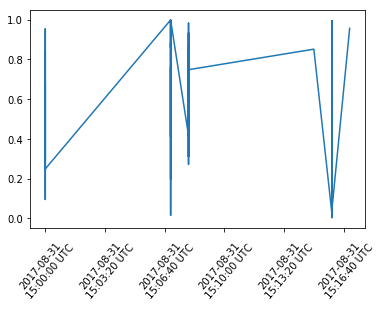

In [229]:
import matplotlib.pyplot as plt

plt.plot(predicted_datetime[:50], predicted_spam[:50])

# get current axis
ax = plt.gca()
# get current xtick labels
xticks = ax.get_xticks()
# convert all xtick labels to selected format
ax.set_xticklabels([pd.to_datetime(tm, unit='s', utc=True).strftime('%Y-%m-%d\n %H:%M:%S %Z') for tm in xticks],
 rotation=50)

plt.show()
